In [21]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

## Yolo model 

In [7]:
# Load the pre-trained YOLOv8 model
model = YOLO('yolov8l.pt')  # Load YOLOv8 large model
model.to('cpu')  # Ensure the model is running on the CPU

# Function to detect objects in an image
def detect_objects(image_path):
    # Check if the image file exists
    if not os.path.isfile(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    # Load the image
    img = cv2.imread(image_path)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Failed to load the image from '{image_path}'.")
        return None
    
    # Resize the image
    img_resized = img #cv2.resize(img, (1280, 1280))

    # Use the model to detect objects
    results = model(img_resized)  # Pass the image to the YOLO model
    #print(results[0])  # Print the results
    results[0].save()  # Save the detection results
    
    return results

# Example usage
results = detect_objects('plastic_fruits.jpeg')  # Replace with the path to your image


0: 640x640 2 bananas, 3 oranges, 5630.7ms
Speed: 12.1ms preprocess, 5630.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


## A) Find the target fruit and mark all other fruits as well

In [17]:
import cv2
from ultralytics import YOLO
import os

# Load YOLOv8 large model
model = YOLO('yolov8l.pt')
model.to('cpu')


def detect_fruit_and_save_image(image_path, target_fruit='apple', output_path='output_image.jpg'):
    # Check if the file exists
    if not os.path.isfile(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    # Load the image
    img = cv2.imread(image_path)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Failed to load the image from '{image_path}'.")
        return None

    # Resize the image for YOLO detection (optional)
    img_resized = img  # cv2.resize(img, (1280, 1280))

    # Use the YOLO model to detect objects
    results = model(img_resized)

    # Get class names
    class_names = model.names

    # Find the class ID for the target fruit
    target_fruit_class_id = None
    for class_id, name in class_names.items():
        if name == target_fruit:
            target_fruit_class_id = class_id
            break

    if target_fruit_class_id is None:
        print(f"Error: The target fruit '{target_fruit}' is not in the YOLO dataset.")
        return None

    target_fruit_positions = []

    # Loop over detections
    for detection in results[0].boxes:
        class_id = int(detection.cls)  # Class ID of the detected object

        # Get bounding box coordinates
        xmin, ymin, xmax, ymax = map(int, detection.xyxy[0])
        # Calculate the center of the bounding box
        x_center = (xmin + xmax) // 2
        y_center = (ymin + ymax) // 2

        # Draw a red dot if the detected fruit is the target fruit, else blue dot
        if class_id == target_fruit_class_id:
            cv2.circle(img_resized, (x_center, y_center), 20, (0, 0, 255), -1)  # Red dot for target fruit
            target_fruit_positions.append((x_center, y_center))
        elif class_id in [46, 47, 49, 50, 51]:  # IDs corresponding to fruits (banana, apple, orange, broccoli, carrot)
            cv2.circle(img_resized, (x_center, y_center), 20, (255, 0, 0), -1)  # Blue dot for other fruits

    # Save the detection image
    cv2.imwrite(output_path, img_resized)
    print(f"Image saved with marked fruits as: {output_path}")

    if target_fruit_positions:
        print(f"Detected {target_fruit} at positions: {target_fruit_positions}")
        return target_fruit_positions
    else:
        print(f"No {target_fruit} detected in the image.")
        return None


# Example usage
image_path = 'plastic_fruits.jpeg'  # Replace with image path
output_image = 'detected_fruits_with_positions.jpg'  # Path to save the image with marked dots
target_fruit = 'banana'  # Specify the fruit to mark with red dots
fruit_positions = detect_fruit_and_save_image(image_path, target_fruit, output_image)

if fruit_positions:
    print(f"{target_fruit.capitalize()} detected. Robot can proceed to pick it up.")
else:
    print(f"No {target_fruit} detected. Robot should not proceed.")



0: 640x640 2 bananas, 3 oranges, 5366.8ms
Speed: 5.9ms preprocess, 5366.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Image saved with marked fruits as: detected_fruits_with_positions.jpg
Detected banana at positions: [(274, 269), (486, 521)]
Banana detected. Robot can proceed to pick it up.


## B) Find coordinates from picture by clicking

In [2]:
import cv2

# Callback function to capture mouse click events
def get_coordinates(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Left mouse button click
        print(f"Coordinates: ({x}, {y})")  # Print the coordinates
        coordinates.append((x, y))  # Save the coordinates in a list

# Load the image
image_path = 'box.jpeg'  # Replace with your image path
img = cv2.imread(image_path)

# Create a list to store coordinates
coordinates = []

# Display the image in a window
cv2.imshow('Image', img)
cv2.setMouseCallback('Image', get_coordinates)  # Set the callback function

# Wait until the user presses the ESC key
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print all collected coordinates
print("Collected coordinates:", coordinates)


2024-09-25 10:48:00.498 python[23121:489508] +[IMKClient subclass]: chose IMKClient_Legacy
2024-09-25 10:48:38.222 python[23121:489508] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


KeyboardInterrupt: 

Collected coordinates: []


## Join A and B above

In [14]:
import cv2
from ultralytics import YOLO
import numpy as np
import os
import matplotlib.pyplot as plt

# Load YOLOv8 large model
model = YOLO('yolov8l.pt')
model.to('cpu')

def detect_fruit_and_save_image(image_path, target_fruit='apple', output_path='output_image.jpg'):
    # Check if the file exists
    if not os.path.isfile(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    # Load the image
    img = cv2.imread(image_path)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Failed to load the image from '{image_path}'.")
        return None

    # Resize the image for YOLO detection (optional)
    img_resized = img  # cv2.resize(img, (1280, 1280))

    def get_coordinates(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:  # Left mouse button click
            print(f"Coordinates: ({x}, {y})")  # Print the coordinates
            coordinates_of_box.append((x, y))  # Save the coordinates in a list

    coordinates_of_box = []

    # MAKE SURE TO CLICK IN THIS ORDER: TOP-LEFT -> TOP-RIGHT -> BOTTOM-RIGHT -> BOTTOM-LEFT -> ANY KEY TO ESCAPE
    cv2.imshow('Image', img_resized)
    cv2.setMouseCallback('Image', get_coordinates)  # Set the callback function
        
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Use the YOLO model to detect objects
    results = model(img_resized)

    # Get class names
    class_names = model.names

    # Find the class ID for the target fruit
    target_fruit_class_id = None
    for class_id, name in class_names.items():
        if name == target_fruit:
            target_fruit_class_id = class_id
            break

    if target_fruit_class_id is None:
        print(f"Error: The target fruit '{target_fruit}' is not in the YOLO dataset.")
        return None

    target_fruit_positions = []

    # Loop over detections
    for detection in results[0].boxes:
        class_id = int(detection.cls)  # Class ID of the detected object

        # Get bounding box coordinates
        xmin, ymin, xmax, ymax = map(int, detection.xyxy[0])
        # Calculate the center of the bounding box
        x_center = (xmin + xmax) // 2
        y_center = (ymin + ymax) // 2

        # Draw a red dot if the detected fruit is the target fruit, else blue dot
        if class_id == target_fruit_class_id:
            cv2.circle(img_resized, (x_center, y_center), 10, (0, 0, 255), -1)  # Red dot for target fruit
            target_fruit_positions.append((x_center, y_center))
        elif class_id in [46, 47, 49, 50, 51]:  # IDs corresponding to fruits (banana, apple, orange, broccoli, carrot)
            cv2.circle(img_resized, (x_center, y_center), 10, (255, 0, 0), -1)  # Blue dot for other fruits

    for (x, y) in coordinates_of_box:
        cv2.circle(img_resized, (x, y), 10, (0, 255, 0), -1)

    
    # Save the detection image
    cv2.imwrite(output_path, img_resized)

    if target_fruit_positions:
        print(f"Detected {target_fruit} at positions: {target_fruit_positions}")
    else:
        print(f"No {target_fruit} detected in the image.")

    x_zero, y_zero = coordinates_of_box[2] #bottom-right corner of box
    x_fruit, y_fruit = target_fruit_positions[0]

    box_size_x_mm = 300 #mm (measured IRL)
    box_size_y_mm = 150 #mm (measured IRL)
    box_size_diag_mm = (box_size_x_mm**2 + box_size_y_mm**2)**0.5 #mm (measured IRL)

    # Calculate distances from picture in x
    box_size_x_pixels_1 = np.linalg.norm(np.array(coordinates_of_box[0])-np.array(coordinates_of_box[1])) #mm (width in pixels from picture)
    box_size_x_pixels_2 = np.linalg.norm(np.array(coordinates_of_box[2])-np.array(coordinates_of_box[3])) #mm (width in pixels from picture)

    # Calculate distances from picture in y
    box_size_y_pixels_1 = np.linalg.norm(np.array(coordinates_of_box[0])-np.array(coordinates_of_box[3])) #mm (width in pixels from picture)
    box_size_y_pixels_2 = np.linalg.norm(np.array(coordinates_of_box[1])-np.array(coordinates_of_box[2])) #mm (width in pixels from picture)

    # Calculate distances from picture in diagonals
    box_size_diag_pixels_1 = np.linalg.norm(np.array(coordinates_of_box[0])-np.array(coordinates_of_box[2])) #mm (width in pixels from picture)
    box_size_diag_pixels_2 = np.linalg.norm(np.array(coordinates_of_box[1])-np.array(coordinates_of_box[3])) #mm (width in pixels from picture)

    # Get mean distances for x and y
    box_size_x_pixels_mean = (box_size_x_pixels_1 + box_size_x_pixels_2) / 2
    box_size_y_pixels_mean = (box_size_y_pixels_1 + box_size_y_pixels_2) / 2
    box_size_diag_pixels_mean = (box_size_diag_pixels_1 + box_size_diag_pixels_2) / 2

    # Get mm per pixel for x and y
    mm_per_pixel_x = box_size_x_mm / box_size_x_pixels_mean # mm / pixel
    mm_per_pixel_y = box_size_y_mm / box_size_y_pixels_mean # mm / pixel
    mm_per_pixel_diag = box_size_diag_mm / box_size_diag_pixels_mean # mm / pixel

    # Get overall mean mm per pixel
    mm_per_pixel = (mm_per_pixel_x + mm_per_pixel_y + mm_per_pixel_diag) / 3
    
    relative_x_fruit_pixels = abs(x_fruit - x_zero)
    relative_y_fruit_pixels = abs(y_fruit - y_zero)

    relative_x_fruit_mm = relative_x_fruit_pixels*mm_per_pixel
    relative_y_fruit_mm = relative_y_fruit_pixels*mm_per_pixel
    
    print(f'\nPixels from {target_fruit} to bottom-right corner:')
    print('x (pixels):', relative_x_fruit_pixels)
    print('x (mm):', relative_x_fruit_mm)
    print()
    print('y (pixles):', relative_y_fruit_pixels)
    print('y (mm):', relative_y_fruit_mm)

    return relative_x_fruit_mm, relative_y_fruit_mm


# Example usage
image_path = 'box.jpeg'  # Replace with image path
output_image = 'box_with_fruits_and_edges_marked.jpg'  # Path to save the image with marked dots
target_fruit = 'banana'  # Specify the fruit to mark with red dots
relative_x_fruit_mm, relative_y_fruit_mm = detect_fruit_and_save_image(image_path, target_fruit, output_image)

Coordinates: (380, 169)
Coordinates: (1298, 149)
Coordinates: (1301, 708)
Coordinates: (395, 723)

0: 384x640 1 banana, 1 orange, 3 books, 13690.2ms
Speed: 4.6ms preprocess, 13690.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Detected banana at positions: [(647, 341)]

Pixels from banana to bottom-right corner:
x (pixels): 654
x (mm): 198.87401907248835

y (pixles): 367
y (mm): 111.60055810336884


## Transform relative fruit position to base system coordinates in mm

In [15]:
# Distances from bottom-right corner of box to the base system of Hubert
box_bottom_right_corner_to_base_system_x = 20 #mm
box_bottom_right_corner_to_base_system_y = 0  #mm
box_bottom_right_corner_to_base_system_z = 50 #mm

relative_z_fruit_mm = 40 #start with set value to begin with

fruit_position_base_system_x = box_bottom_right_corner_to_base_system_x + relative_y_fruit_mm
fruit_position_base_system_y = box_bottom_right_corner_to_base_system_y + relative_x_fruit_mm
fruit_position_base_system_x = box_bottom_right_corner_to_base_system_z + relative_z_fruit_mm

fruit_position_base_system = [fruit_position_base_system_x, fruit_position_base_system_y, fruit_position_base_system_y]

print(fruit_position_base_system)

[90, 198.87401907248835, 198.87401907248835]


## Try NN to find joint angles

In [23]:
import numpy as np

# Define rotation matrices and translation matrix from Part A
def RotX(theta):
    return np.array([
        [1, 0, 0, 0],
        [0, np.cos(theta), -np.sin(theta), 0],
        [0, np.sin(theta), np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

def RotY(theta):
    return np.array([
        [np.cos(theta), 0, np.sin(theta), 0],
        [0, 1, 0, 0],
        [-np.sin(theta), 0, np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

def RotZ(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0, 0],
        [np.sin(theta), np.cos(theta), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def translation_matrix(t_x, t_y, t_z):
    return np.array([
        [1, 0, 0, t_x],
        [0, 1, 0, t_y],
        [0, 0, 1, t_z],
        [0, 0, 0, 1]
    ])

# Forward kinematics function
def forward_kinematics(theta_1, theta_2, theta_3):
    # Link lengths from Part A (in meters)
    L1 = 0.055
    L2 = 0.315 
    L3 = 0.045 
    L4 = 0.108 
    L5 = 0.005 
    L6 = 0.034 
    L7 = 0.015 
    L8 = 0.088 
    L9 = 0.204 

    # Transformations between coordinate frames
    trans_0_to_1 = translation_matrix(L6, -L4, (L2 + L3))
    trans_1_to_2 = translation_matrix(L7, -L8, -L5)
    trans_2_to_3 = translation_matrix(0, -L9, 0)

    # Rotations around the Z-axis for each joint
    rot_theta_z_1 = RotZ(theta_1)
    rot_theta_z_2 = RotZ(theta_2)
    rot_theta_z_3 = RotZ(theta_3)

    # Transformation from frame 0 to frame 1 (including rotation and translation)
    trans_1 = rot_theta_z_1 @ trans_0_to_1 @ RotX(np.pi / 2)

    # Transformation from frame 1 to frame 2
    trans_2 = rot_theta_z_2 @ trans_1_to_2

    # Transformation from frame 2 to frame 3
    trans_3 = rot_theta_z_3 @ trans_2_to_3

    # Homogeneous coordinates of the end-effector
    end_effector_position = np.array([0, 0, 0, 1])

    # Final position of the end-effector in the base frame
    final_position = trans_1 @ trans_2 @ trans_3 @ end_effector_position

    # Return the end-effector position (x, y, z) in the base frame
    return final_position[:3]

# Example usage
theta_1 = np.pi / 4  # Example joint angles in radians
theta_2 = np.pi / 3
theta_3 = np.pi / 6

position = forward_kinematics(theta_1, theta_2, theta_3)
print("End-effector position [x, y, z]:", position)


End-effector position [x, y, z]: [    0.30032     0.15465     0.32899]


In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the neural network model
class InverseKinematicsNN(nn.Module):
    def __init__(self):
        super(InverseKinematicsNN, self).__init__()
        self.fc1 = nn.Linear(3, 64)  # Input layer (x, y, z) -> 64 neurons
        self.fc2 = nn.Linear(64, 128)  # Hidden layer -> 128 neurons
        self.fc3 = nn.Linear(128, 64)  # Hidden layer -> 64 neurons
        self.fc4 = nn.Linear(64, 3)   # Output layer -> (theta_1, theta_2, theta_3)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.fc4(x)  # Output angles in radians
        return x

# Instantiate the model, define loss function and optimizer
model = InverseKinematicsNN()
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Generate synthetic training data (example)
def generate_training_data(num_samples):
    X = []
    Y = []

    for _ in range(num_samples):
        # Random joint angles in radians
        theta_1 = np.random.uniform(0, np.pi)
        theta_2 = np.random.uniform(0, np.pi)
        theta_3 = np.random.uniform(0, np.pi/2)

        # Forward kinematics to get the end-effector position
        pos = forward_kinematics(theta_1, theta_2, theta_3)

        # Input: (x, y, z), Output: (theta_1, theta_2, theta_3)
        X.append(pos)
        Y.append([theta_1, theta_2, theta_3])

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

# Prepare data
X_train, Y_train = generate_training_data(2000) #X=pos, Y=angels
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/2000], Loss: 0.2464
Epoch [200/2000], Loss: 0.1576
Epoch [300/2000], Loss: 0.1198
Epoch [400/2000], Loss: 0.0914
Epoch [500/2000], Loss: 0.0727
Epoch [600/2000], Loss: 0.0567
Epoch [700/2000], Loss: 0.0490
Epoch [800/2000], Loss: 0.0442
Epoch [900/2000], Loss: 0.0422
Epoch [1000/2000], Loss: 0.0386
Epoch [1100/2000], Loss: 0.0368
Epoch [1200/2000], Loss: 0.0349
Epoch [1300/2000], Loss: 0.0333
Epoch [1400/2000], Loss: 0.0318
Epoch [1500/2000], Loss: 0.0305
Epoch [1600/2000], Loss: 0.0296
Epoch [1700/2000], Loss: 0.0286
Epoch [1800/2000], Loss: 0.0284
Epoch [1900/2000], Loss: 0.0271
Epoch [2000/2000], Loss: 0.0265


In [90]:
# Test the model with an example input
position = forward_kinematics(0, np.pi/2, 0)

P_target = [0.30031549, 0.15465149, 0.32899038]

model.eval()
test_position = torch.tensor(P_target, dtype=torch.float32)  # Example (x, y, z)
predicted_angles = model(test_position)
predicted_angles = predicted_angles.detach().numpy()
predicted_theta_1 = predicted_angles[0]
predicted_theta_2 = predicted_angles[1]
predicted_theta_3 = predicted_angles[2]

P_predicted = forward_kinematics(predicted_theta_1, predicted_theta_2, predicted_theta_3)
error = np.linalg.norm(P_target - P_predicted)

theta_1 = np.pi / 4  # Example joint angles in radians
theta_2 = np.pi / 3
theta_3 = np.pi / 6

print("Predicted joint angles (theta_1, theta_2, theta_3):", predicted_angles)
print("True joint angles (theta_1, theta_2, theta_3):", [theta_1, theta_2, theta_3])
print()
print('P_predicted ', P_predicted)
print('P_target ', P_target)
print('Error: ', error)

Predicted joint angles (theta_1, theta_2, theta_3): [    0.84689      1.1453      0.4227]
True joint angles (theta_1, theta_2, theta_3): [0.7853981633974483, 1.0471975511965976, 0.5235987755982988]

P_predicted  [    0.29199     0.17479     0.33678]
P_target  [0.30031549, 0.15465149, 0.32899038]
Error:  0.023141538501017588


## Other

In [9]:
model = YOLO('yolov8l.pt')  # Load YOLOv8 large model
model.to('cpu')  


def detect_apple_and_save_image(image_path, output_path='output_image.jpg'):
    # Check if the file exists
    if not os.path.isfile(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    # Load the image
    img = cv2.imread(image_path)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Failed to load the image from '{image_path}'.")
        return None

    # Get the dimensions of the image
    height, width, _ = img.shape

    # Print the pixel coordinates for the corners of the image
    print(f"Corner coordinates of the image:")
    print(f"Top-left corner: (0, 0)")
    print(f"Top-right corner: ({width-1}, 0)")
    print(f"Bottom-left corner: (0, {height-1})")
    print(f"Bottom-right corner: ({width-1}, {height-1})")

    # Draw blue circles at each corner of the image
    cv2.circle(img, (0, 0), 20, (255, 0, 0), -1)  # Top-left corner
    cv2.circle(img, (width-1, 0), 20, (255, 0, 0), -1)  # Top-right corner
    cv2.circle(img, (0, height-1), 20, (255, 0, 0), -1)  # Bottom-left corner
    cv2.circle(img, (width-1, height-1), 20, (255, 0, 0), -1)  # Bottom-right corner

    # Resize the image for YOLO detection (optional)
    img_resized = img  # cv2.resize(img, (1280, 1280))

    # Use the YOLO model to detect objects
    results = model(img_resized)

    # Get class names
    class_names = model.names
    
    apple_class_id = 47  # 'apple' class in YOLO (from the COCO dataset)
    apple_found = False
    apple_position = None

    # Loop over detections and check if an apple is detected
    for detection in results[0].boxes:
        class_id = int(detection.cls)  # Class ID of the detected object
        if class_id == apple_class_id:  # Check if it is an apple
            apple_found = True

            # Get bounding box coordinates
            xmin, ymin, xmax, ymax = map(int, detection.xyxy[0])
            # Calculate the center of the apple's bounding box
            x_center = (xmin + xmax) // 2
            y_center = (ymin + ymax) // 2

            # Store the position of the apple
            apple_position = (x_center, y_center)

            # Draw a red dot at the center of the apple's bounding box
            cv2.circle(img_resized, (x_center, y_center), 20, (0, 0, 255), -1)  # Red dot
            
            break  # We found the apple, no need to check further

    # Save the detection image
    results[0].save()  # YOLO saves the image with bounding boxes
   
    if apple_found:
        cv2.imwrite(output_path, img_resized)
        print(f"Apple detected at position: {apple_position}")
        print(f"Image with red dot saved as: {output_path}")
        return apple_position
    else:
        print("No apple detected in the image.")
        return None

# Example usage
namn = 'apple1'

image_path = namn + '.jpg'  # Replace with image path
output_image = namn + '_FOUND_AND_MARKED.jpg'  # Path to save the image with a red dot and blue corners
apple_position = detect_apple_and_save_image(image_path, output_image)

if apple_position:
    print("Apple detected. Robot can proceed to pick it up.")
else:
    print("No apple detected. Robot should not proceed.")


Corner coordinates of the image:
Top-left corner: (0, 0)
Top-right corner: (1124, 0)
Bottom-left corner: (0, 1499)
Bottom-right corner: (1124, 1499)

0: 640x480 1 person, 1 apple, 1 keyboard, 4942.3ms
Speed: 10.8ms preprocess, 4942.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)
Apple detected at position: (376, 876)
Image with red dot saved as: apple1_FOUND_AND_MARKED.jpg
Apple detected. Robot can proceed to pick it up.


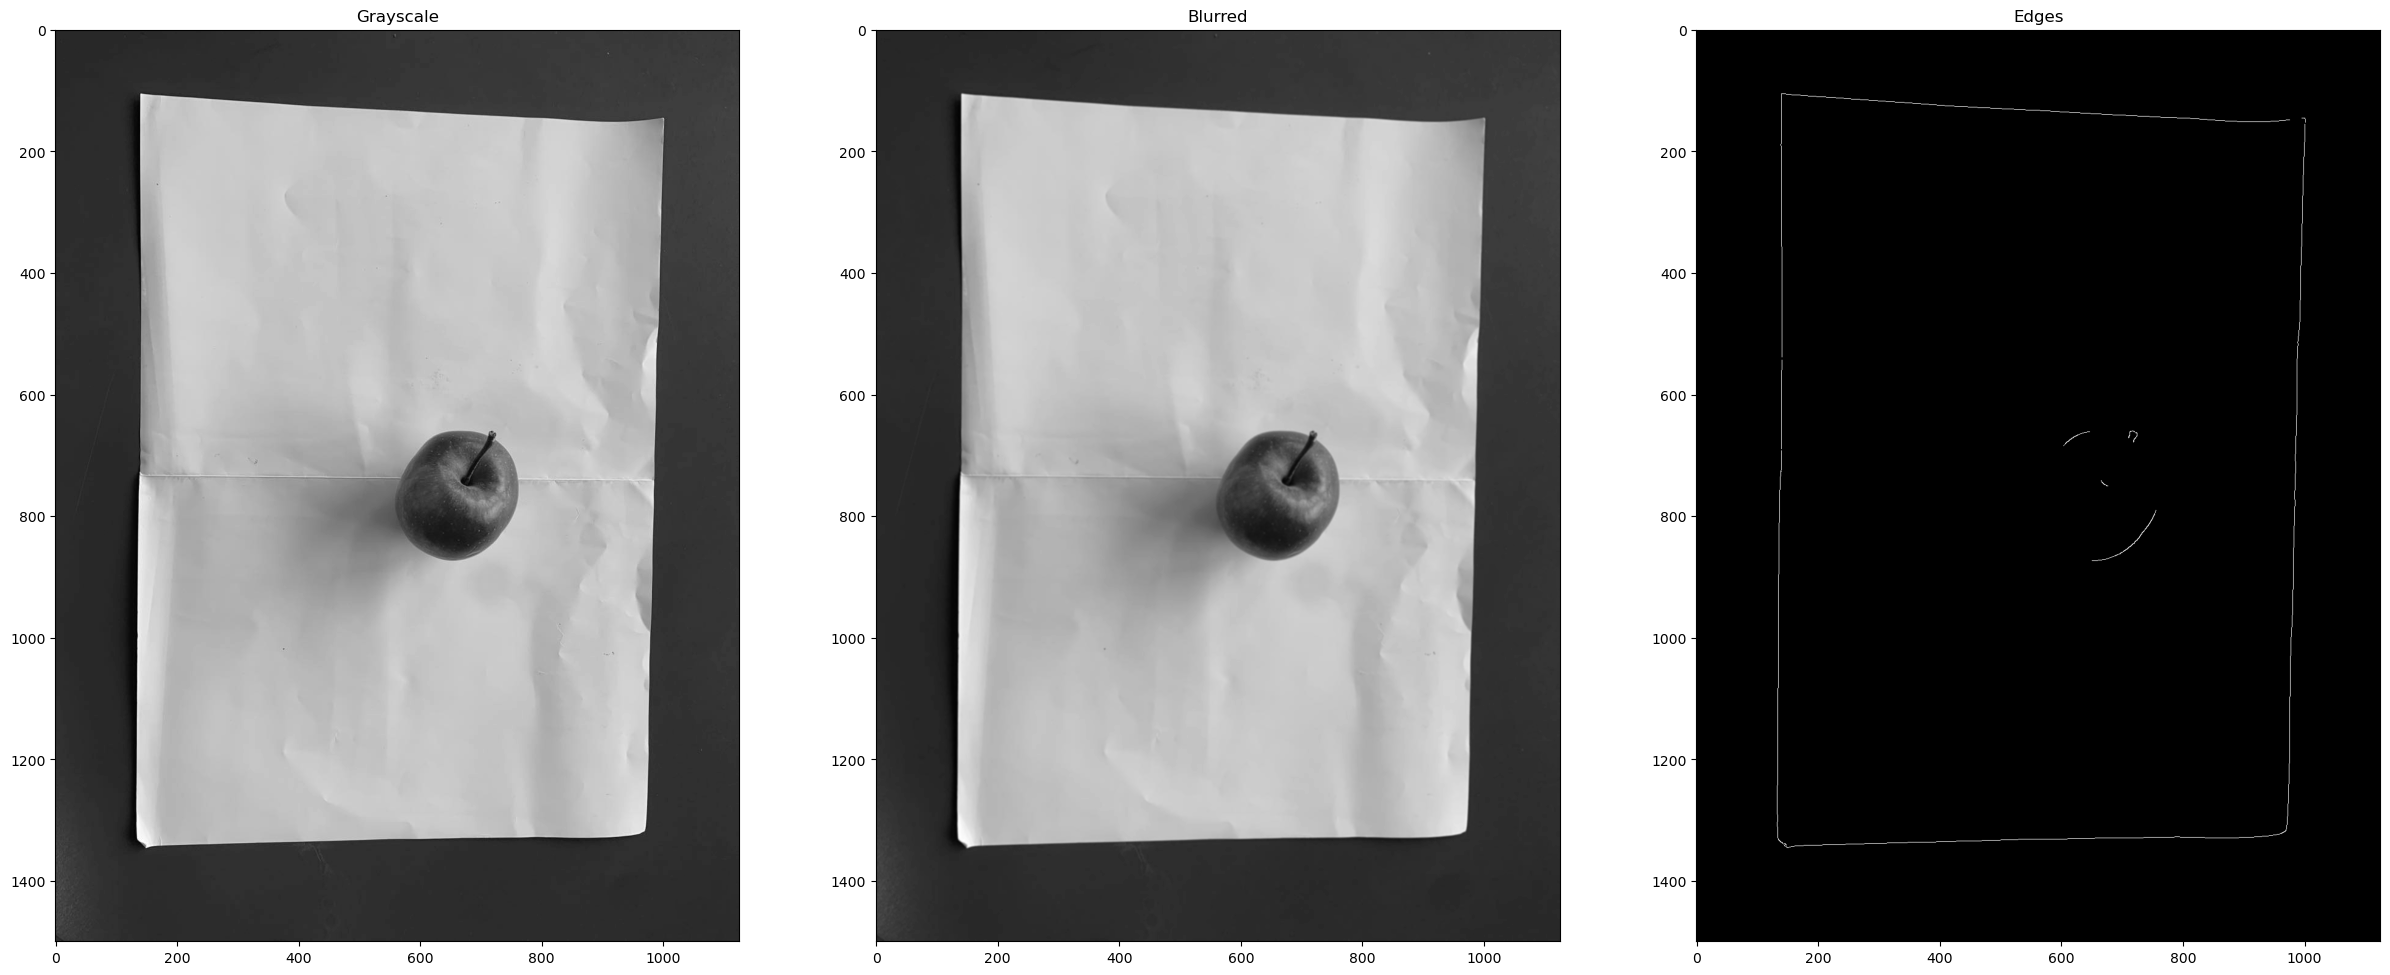

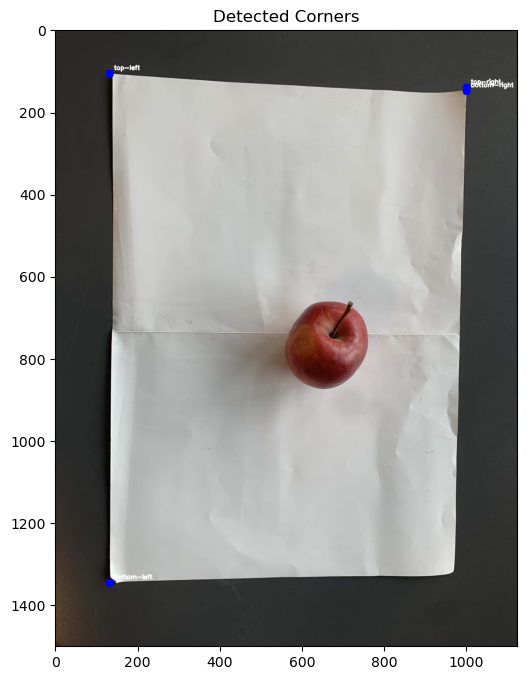

{'top-left': (133, 106),
 'top-right': (1002, 140),
 'bottom-left': (133, 1346),
 'bottom-right': (1002, 148)}

In [59]:
import cv2
from ultralytics import YOLO
import os
import numpy as np
import matplotlib.pyplot as plt

# Load YOLOv8 model
model = YOLO('yolov8l.pt')  # Load YOLOv8 large model
model.to('cpu')  # Use CPU

def detect_paper_corners(image_path):
    """Detect corners of a paper using contour detection."""
    # Convert the image to grayscale
    image = cv2.imread(image_path)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(30, 20))
    
    # Plot grayscale image
    plt.subplot(131)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Plot blurred image
    plt.subplot(132)
    plt.imshow(blurred, cmap='gray')
    plt.title('Blurred')

    # Apply Canny Edge detection
    edges = cv2.Canny(blurred, 250, 300)

    # Plot edges image
    plt.subplot(133)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges')
    
    plt.show()  # Display the plots

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to store the extreme points
    max_x = max_y = -np.inf
    min_x = min_y = np.inf

    # Loop over contours to find the largest contour (assuming it's the paper)
    for contour in contours:
        for point in contour:
            x, y = point[0]
            
            # Update extreme values
            if x < min_x:
                min_x = x
                min_x_y = y  # Corresponding y for smallest x
            if x > max_x:
                max_x = x
                max_x_y = y  # Corresponding y for largest x
            if y < min_y:
                min_y = y
                min_y_x = x  # Corresponding x for smallest y
            if y > max_y:
                max_y = y
                max_y_x = x  # Corresponding x for largest y

    # Store the four corners
    corners = {
        "top-left": (min_x, min_y),
        "top-right": (max_x, min_y_x),
        "bottom-left": (min_x, max_y),
        "bottom-right": (max_x, max_x_y)
    }

    # Draw the corners on the image
    for corner_name, (x, y) in corners.items():
        cv2.circle(image, (x, y), 10, (255, 0, 0), -1)  # Blue circles for corners
        cv2.putText(image, corner_name, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Plot the original image with detected corners
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Corners')
    plt.show()

    return corners

image_path = 'appleonpaper3.jpg'
detect_paper_corners(image_path)

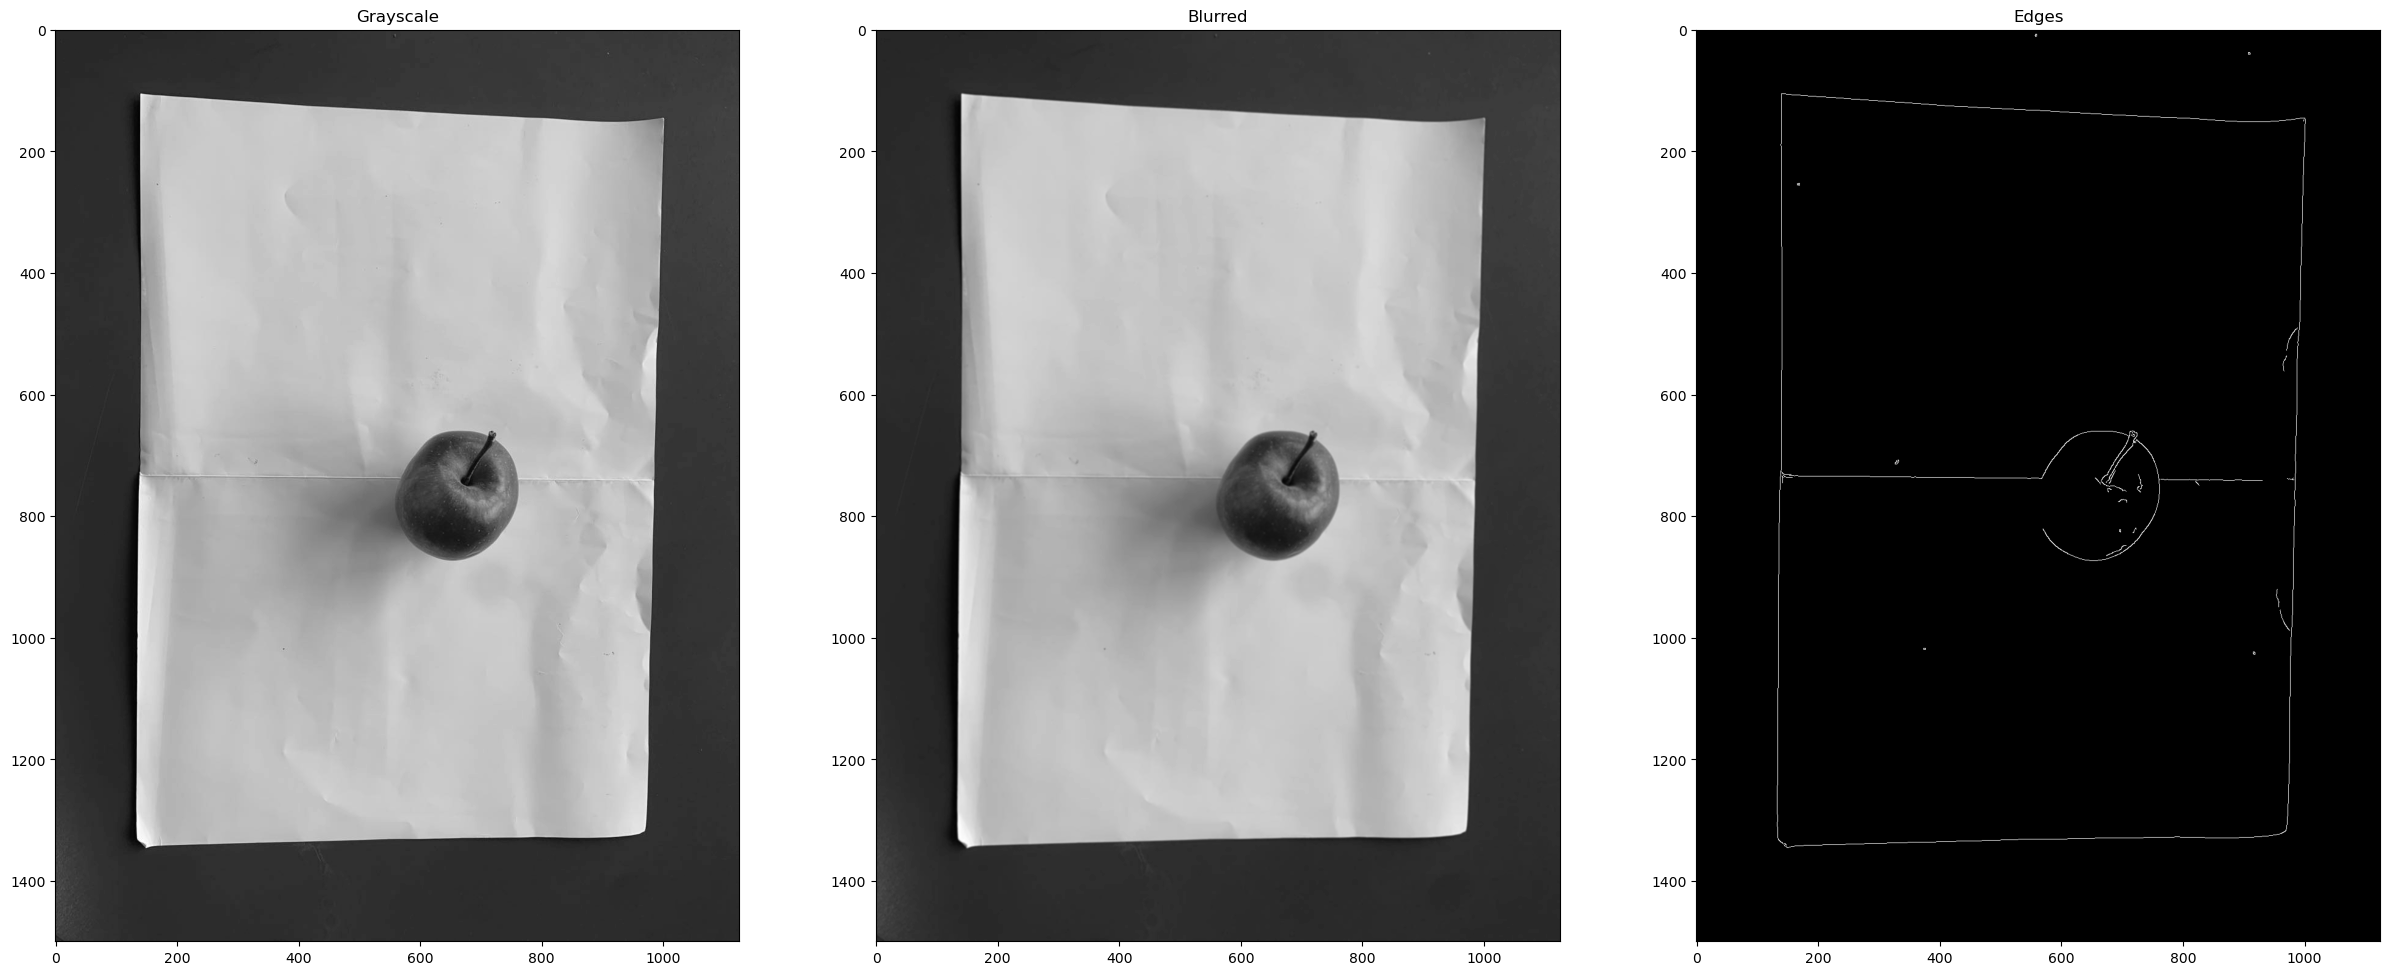

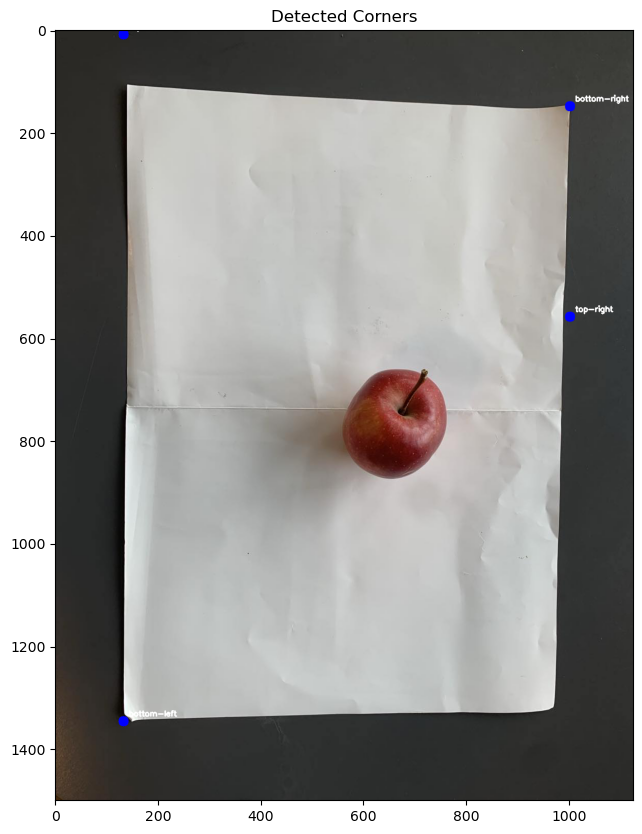

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Expected sequence length 2, got 1
>  - Can't parse 'center'. Expected sequence length 2, got 1


In [ ]:
def is_point_in_polygon(point, polygon):
    """Check if a point (apple) is inside a polygon (paper)."""
    result = cv2.pointPolygonTest(polygon, point, False)
    return result >= 0

def detect_apple_and_check_paper(image_path, output_path='output_image.jpg'):
    # Check if the file exists
    if not os.path.isfile(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    # Load the image
    img = cv2.imread(image_path)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Failed to load the image from '{image_path}'.")
        return None

    # Detect paper corners
    paper_corners = detect_paper_corners(img)
    if paper_corners is None:
        print("Error: Could not detect the paper in the image.")
        return None

    # Draw the detected paper corners
    for corner in paper_corners:
        cv2.circle(img, tuple(corner[0]), 10, (255, 0, 0), -1)  # Blue circles for corners

    # Use YOLO model to detect objects
    results = model(img)

    # Get class names and apple class id (from COCO dataset)
    class_names = model.names
    apple_class_id = 47  # 'apple' class in YOLO

    apple_found = False
    apple_position = None

    # Loop over detections and check if an apple is detected
    for detection in results[0].boxes:
        class_id = int(detection.cls)  # Class ID of the detected object
        if class_id == apple_class_id:  # Check if it is an apple
            apple_found = True

            # Get bounding box coordinates
            xmin, ymin, xmax, ymax = map(int, detection.xyxy[0])
            # Calculate the center of the apple's bounding box
            x_center = (xmin + xmax) // 2
            y_center = (ymin + ymax) // 2
            apple_position = (x_center, y_center)

            # Draw a red dot at the center of the apple's bounding box
            cv2.circle(img, (x_center, y_center), 20, (0, 0, 255), -1)  # Red dot

            # Check if apple is inside the paper
            if is_point_in_polygon(apple_position, paper_corners):
                print(f"Apple is inside the paper frame at position: {apple_position}")
            else:
                print(f"Apple is outside the paper frame at position: {apple_position}")

            break  # We found the apple, no need to check further

    # Save the detection image
    if apple_found:
        cv2.imwrite(output_path, img)

        # Convert BGR to RGB for displaying using matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title('Final Detection')
        plt.show()

        print(f"Image with detected apple and paper saved as: {output_path}")
    else:
        print("No apple detected in the image.")

# Example usage
image_path = 'appleonpaper3.jpg'  # Replace with the path to your image
output_image = 'apple_in_paper_frame.jpg'  # Path to save the image with detections
detect_apple_and_check_paper(image_path, output_image)